# Poisson and Binomial: Fitting the Number of tumour cells killed per NK cell curve.

**Mathematical Model** 

Over duration $T$, each NK kills targets in a rate of $r$ (kills per unit time). Set $\lambda = r \cdot T$. Therefore, the number of the targets killed per NK cell $N$ follows a Poisson distribution: 

$$
N \sim \mathrm{Poisson}(\lambda), \qquad 
P(N) = e^{-\lambda}\frac{(\lambda)^N}{N!}.
$$

In one of the experimental replicates, let $M$ be the number of NK cell observations (total number of NK cells analysed) and $K_{N}$ be the number of NK cells that killed exactly $N$ targets. $
K_0 + K_1 + K_2 + \dots + K_n = M $

Therefore, $K_{N}$ in all of the experimental replicates follows a binomial distribution:

$$
K_N \sim \mathrm{Binomial}(M,P(N)),\qquad
P(K_N)=\binom{M}{K_N} \cdot P(N)^{K_N} \cdot(1-P(N))^{M-K_N}
$$


In [40]:
import numpy as np
from scipy.stats import poisson
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, MaxNLocator

import pymc as pm
import arviz as az

import pytensor.tensor as pt
from pytensor.tensor.special import gammaln  # << use this

import seaborn as sns
import pandas as pd
import os
from pathlib import Path

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000  

## Synthetic Data


In [4]:
def experiment(
    killing_rate: float = 0.01,
    Duration: float = 60,
    Killer_cell_number_min: int = 75,
    Killer_cell_number_max: int = 120,
    replicate: int = 10,
    seed: int = 66,
):
    kills = []
    lam = killing_rate * Duration
    rng = np.random.default_rng(seed)
    arr = rng.integers(Killer_cell_number_min, Killer_cell_number_max, size=replicate) 
    for K_NUM in arr:
        kill = poisson.rvs(mu=lam, size=(K_NUM), random_state=rng) 
        kills.append(kill)
    return kills


In [5]:
rate_list = [0.005, 0.02, 0.04] 
T = 60 
lambda_list = [rate * T for rate in rate_list]
replicate = 10

synthetic_data = {
    rate: experiment(killing_rate=rate, Duration=T, replicate=replicate)
    for rate in rate_list
}

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_30772/2525236258.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = get_cmap('YlGnBu')


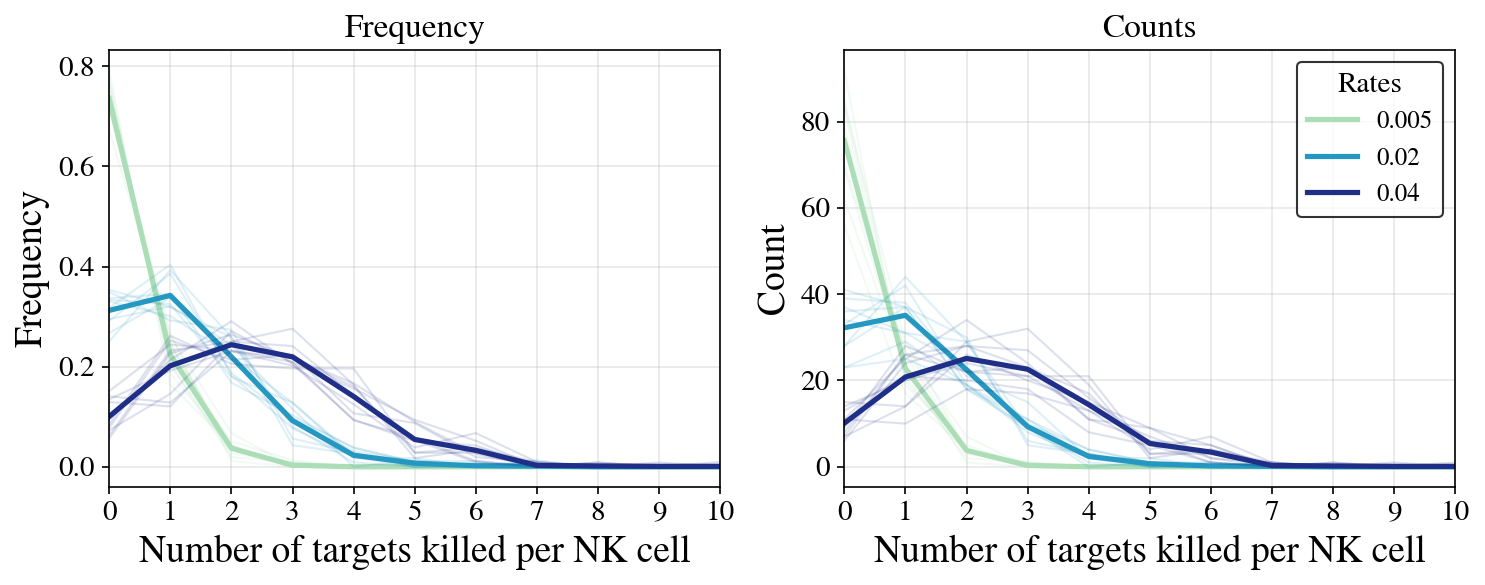

In [6]:
rates = sorted(synthetic_data.keys())
flat_reps = [arr for rate in rates for arr in synthetic_data[rate] if arr.size > 0]
k_max = int(np.max([a.max() for a in flat_reps])) if flat_reps else 0
k_vals = np.arange(0, k_max + 1)

base = get_cmap('YlGnBu')
start, stop = 0.3, 0.9
colors = base(np.linspace(start, stop, len(rates)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=150, sharex=True)
ax_freq, ax_count = axes

for i, rate in enumerate(rates):
    reps = synthetic_data[rate]  
    colour = colors[i]

    counts_all, freqs_all = [], []

    # Each replicate (faint lines)
    for rep_arr in reps:
        rep_arr = np.asarray(rep_arr, dtype=int)
        if rep_arr.size == 0:
            continue
        n_cells = rep_arr.size
        counts = np.bincount(rep_arr, minlength=k_max + 1)
        freq = counts / n_cells

        counts_all.append(counts)
        freqs_all.append(freq)

        ax_freq.plot(k_vals, freq, alpha=0.15, color=colour, linewidth=1)
        ax_count.plot(k_vals, counts, alpha=0.15, color=colour, linewidth=1)

    # Mean across replicates (bold)
    if freqs_all: 
        freqs_mean = np.mean(np.vstack(freqs_all), axis=0)
        counts_mean = np.mean(np.vstack(counts_all), axis=0)
        ax_freq.plot(k_vals, freqs_mean, color=colour, linewidth=2.5, label=f"{rate}")
        ax_count.plot(k_vals, counts_mean, color=colour, linewidth=2.5, label=f"{rate}")

ax_freq.set_title("Frequency")
ax_count.set_title("Counts")
ax_freq.set_ylabel("Frequency")
ax_count.set_ylabel("Count")
for ax in (ax_freq, ax_count):
    ax.set_xlabel("Number of targets killed per NK cell")
    ax.set_xlim(0, k_max)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(True, alpha=0.3)

ax_count.legend(title = "Rates", frameon=True, edgecolor='black', loc='upper right')
plt.tight_layout()
plt.show()

## Bayesian Inference to estimate the rates

**Markov chain Monte Carlo (MCMC) methods**

<p align="left">
  <img src="https://raw.githubusercontent.com/pymc-devs/brand/main/pymc/pymc_logos/PyMC_banner.svg" alt="My Figure" width="100"/>
  <!-- <br>
  <em>Figure 1. A centred figure with caption</em> -->
</p>

In [39]:
data_list = [synthetic_data[r] for r in synthetic_data.keys()]


In [ ]:
for i, experimental_data in enumerate(data_list):
    all_cells = np.concatenate([np.asarray(rep, int) for rep in experimental_data if len(rep) > 0])
    Kcut = int(all_cells.max()) + 3
    K = np.bincount(np.clip(all_cells, 0, Kcut - 1), minlength=Kcut).astype("int64")
    M = int(K.sum())
    
    with pm.Model() as model:
        # Prior on log10(lambda)
        eta = pm.Uniform("eta", lower=-2.0, upper=2.0)      # eta = log10(lambda)
        lam = pm.Deterministic("lam", 10.0 ** eta)          # use ** or pt.power(10.0, eta)
        r   = pm.Deterministic("r", lam / T)

        # Poisson pmf for k = 0 .. Kcut-2 (log-space for stability)
        ks = pt.arange(Kcut - 1)                            # 0,1,...,Kcut-2
        logpmf = -lam + ks * pt.log(lam) - gammaln(ks + 1)  # << gammaln from pt.special
        pmf = pt.exp(logpmf)

        # Tail probability (>= Kcut-1)
        tail = 1.0 - pt.sum(pmf)

        # Numerical safety: clip & renormalise
        pmf  = pt.clip(pmf, 1e-16, 1.0)
        tail = pt.clip(tail, 1e-16, 1.0)
        probs = pt.concatenate([pmf, tail[None]])
        probs = probs / pt.sum(probs)

        # Multinomial likelihood
        pm.Multinomial("K", n=M, p=probs, observed=K)

        idata = pm.sample(
            draws=2000, tune=2000, chains=4,
            target_accept=0.9, random_seed=42, progressbar=True
        )

In [52]:
def inference(experimental_data, T=60.0, draws=2000, tune=2000, chains=4, seed=42):
    """
    experimental_data: list of 1-D arrays (replicates), each holding per-cell kill counts
    returns: ArviZ InferenceData
    """
    # flatten per-cell counts across replicates
    all_cells = np.concatenate([np.asarray(rep, int) for rep in experimental_data if len(rep) > 0])
    # bins 0..Kcut-2 explicitly, tail bin at Kcut-1
    Kcut = int(all_cells.max()) + 3
    K = np.bincount(np.clip(all_cells, 0, Kcut - 1), minlength=Kcut).astype("int64")
    M = int(K.sum())
    
    # MCMC
    with pm.Model() as model:
        # prior on log10(lambda)
        eta = pm.Uniform("eta", lower=-2.0, upper=2.0)     # eta = log10(lambda)
        lam = pm.Deterministic("lam", 10.0 ** eta)
        r   = pm.Deterministic("r", lam / T)               # per-time rate

        # Poisson pmf for categories 0..Kcut-2 (log-space)
        ks = pt.arange(Kcut - 1)
        logpmf = -lam + ks * pt.log(lam) - gammaln(ks + 1)
        pmf = pt.exp(logpmf)

        # tail (>= Kcut-1), clip + renormalise just in case
        tail = 1.0 - pt.sum(pmf)
        pmf  = pt.clip(pmf, 1e-16, 1.0)
        tail = pt.clip(tail, 1e-16, 1.0)
        probs = pt.concatenate([pmf, tail[None]])
        probs = probs / pt.sum(probs)

        pm.Multinomial("K", n=M, p=probs, observed=K)

        idata = pm.sample(
            draws=draws, tune=tune, chains=chains,
            target_accept=0.9, random_seed=seed, progressbar=True)

        # attach log_likelihood (handy for plotting colour scales etc.)
        try:
            idata = pm.compute_log_likelihood(idata, extend_inferencedata=True)
        except Exception:
            pass

    return idata


def run_inference_for_list(data_list, T=60.0, labels=None, seed0=42):
    """
    data_list: list where each item is `experimental_data` (list of 1-D arrays per replicate)
    returns: list of (label, idata), where idata is the InferenceData from `inference(...)`.
    """
    if labels is None:
        labels = [f"cond_{i}" for i in range(len(data_list))]

    out = []
    for i, experimental_data in enumerate(data_list):
        lbl = str(labels[i])
        print(f"Fitting {lbl} ...")
        idata = inference(experimental_data, T=T, seed=seed0 + i)
        out.append((lbl, idata))
    return out


def plot_rate_posteriors(
    idatas,
    style="kde",              # "kde" or "hist" (overlayed in ONE diagram)
    hdi_prob=0.95,
    export_pdf=False,
    pdf_path="rate_posteriors.pdf",
    bins=100,
    density=False,            # True=normalised density; False=counts
    show_mean=True,
    legend_show_mean=True,    # <-- put posterior mean in legend text
    legend_fmt=".3g",         # <-- format for the mean in legend
    legend_loc="best",        # <-- where to place the legend
):
    """
    idatas: list of (label, idata) as returned by run_inference_for_list()
    style : "kde" for overlaid density curves; "hist" for overlaid histograms on ONE axis
    """
    # Collect posterior draws of r into a tidy DataFrame
    frames, order = [], []
    for label, idata in idatas:
        r_da = idata.posterior["r"]  # dims ('chain','draw')
        r_vals = r_da.stack(sample=("chain", "draw")).values.astype(float).ravel()
        frames.append(pd.DataFrame({"r": r_vals, "label": label}))
        order.append(label)
    all_df = pd.concat(frames, ignore_index=True)

    # HDIs & posterior means per label
    hdi_map = {}
    mean_map = {}
    for lab in order:
        vals = all_df.loc[all_df["label"] == lab, "r"].to_numpy()
        hdi_map[lab] = tuple(az.hdi(vals, hdi_prob=hdi_prob))
        mean_map[lab] = float(np.mean(vals))

    # Helper to make legend text
    def _legend_label(lab):
        if legend_show_mean:
            return f"{lab} (μ={format(mean_map[lab], legend_fmt)})"
        return lab

    sns.set_context("talk", font_scale=0.9)
    palette = sns.color_palette("YlGnBu", n_colors=len(order))

    if style.lower() == "kde":
        # -------- Overlaid KDEs --------
        fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
        for c, lab in zip(palette, order):
            sdf = all_df.loc[all_df["label"] == lab]
            sns.kdeplot(data=sdf, x="r", ax=ax, linewidth=2, color=c,
                        label=_legend_label(lab), fill=True, alpha=0.15)
            lo, hi = hdi_map[lab]
            ax.axvline(lo, color=c, linestyle="--", linewidth=1)
            ax.axvline(hi, color=c, linestyle="--", linewidth=1)
            if show_mean:
                ax.axvline(mean_map[lab], color=c, linestyle="-", linewidth=1, alpha=0.8)

        ax.set_xlabel("Rate (per time)")
        ax.set_ylabel("Density")
        ax.set_title(f"Posterior of rate (HDI {int(hdi_prob*100)}%)")
        ax.legend(frameon=False, loc=legend_loc)

    else:
        # -------- Overlaid histograms on ONE axis --------
        fig, ax = plt.subplots(figsize=(7.5, 4.5), dpi=150)
        rmin, rmax = all_df["r"].min(), all_df["r"].max()
        span = (rmax - rmin) or 1e-6
        rmin, rmax = rmin - 0.02 * span, rmax + 0.02 * span
        edges = np.linspace(rmin, rmax, bins + 1)

        for c, lab in zip(palette, order):
            vals = all_df.loc[all_df["label"] == lab, "r"].to_numpy()
            # filled translucent + outline for readability
            ax.hist(vals, bins=edges, density=density, histtype="stepfilled",
                    alpha=0.18, color=c, label=None)
            ax.hist(vals, bins=edges, density=density, histtype="step",
                    linewidth=1.8, color=c, label=_legend_label(lab))

            # HDI shading and lines
            lo, hi = hdi_map[lab]
            ax.axvspan(lo, hi, color=c, alpha=0.08, linewidth=0)
            ax.axvline(lo, color=c, linestyle="--", linewidth=1)
            ax.axvline(hi, color=c, linestyle="--", linewidth=1)
            if show_mean:
                ax.axvline(mean_map[lab], color=c, linestyle="-", linewidth=1, alpha=0.9)

        ax.set_xlabel("Rate (per time)")
        ax.set_ylabel("Density" if density else "Count")
        ax.set_title(f"Posterior of rate — overlaid histograms (HDI {int(hdi_prob*100)}%)")
        ax.legend(frameon=False, loc=legend_loc)

    plt.tight_layout()
    if export_pdf:
        fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
        print(f"Saved PDF: {pdf_path}")
    plt.show()

Initializing NUTS using jitter+adapt_diag...


Fitting rate_0.005 ...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Initializing NUTS using jitter+adapt_diag...


Fitting rate_0.02 ...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Initializing NUTS using jitter+adapt_diag...


Fitting rate_0.04 ...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

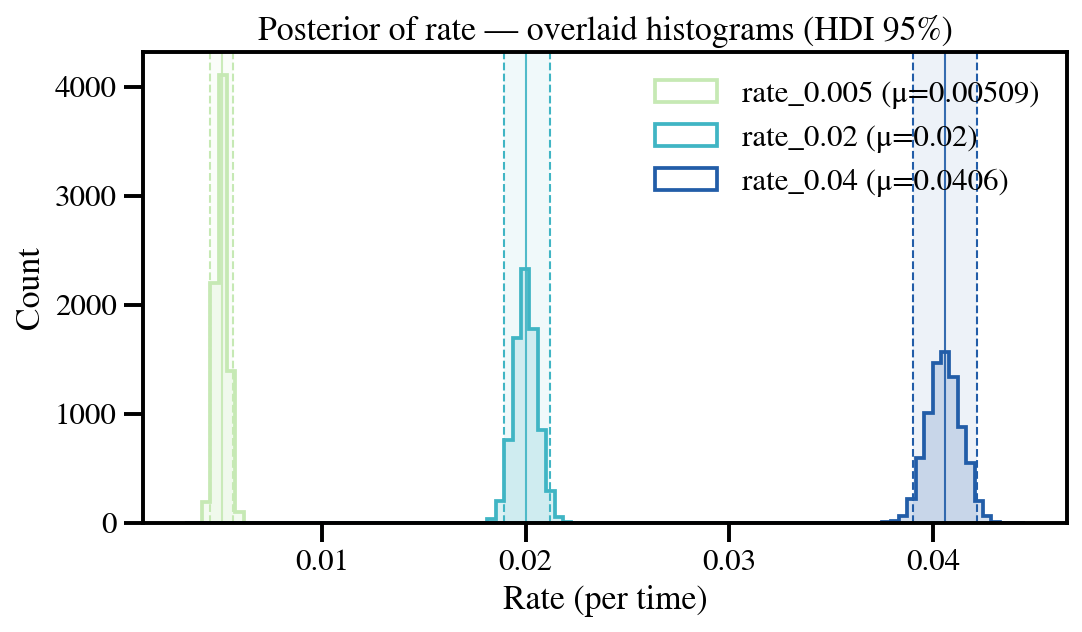

In [53]:
labels = [f"rate_{r:g}" for r in sorted(synthetic_data.keys())]
data_list = [synthetic_data[r] for r in sorted(synthetic_data.keys())]

idatas = run_inference_for_list(data_list, T=T, labels=labels)
plot_rate_posteriors(
    idatas, style="facet", hdi_prob=0.95,
    export_pdf=False)


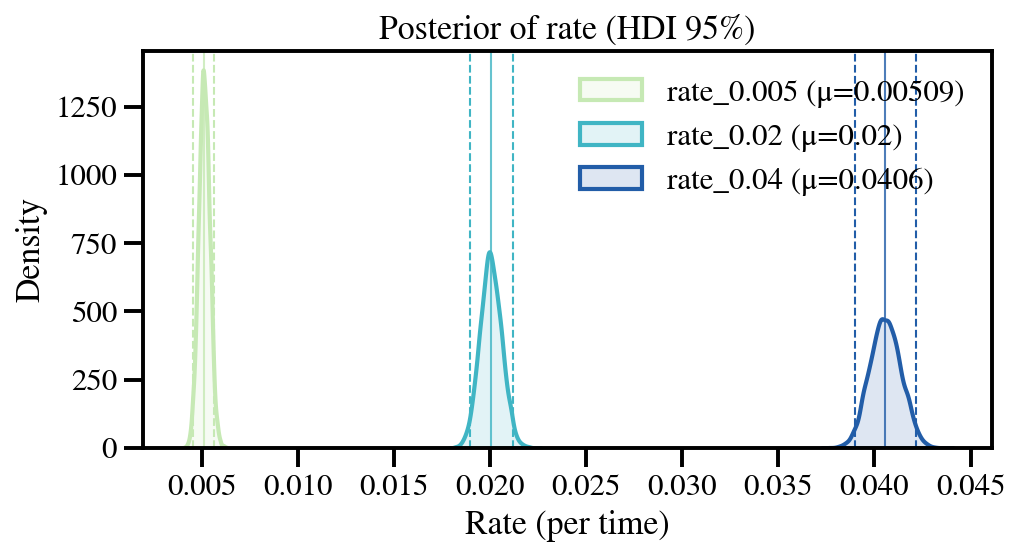

In [ ]:
plot_rate_posteriors(
    idatas, style="kde", hdi_prob=0.95,
    export_pdf=False)